## Risk management: market risk

### Overview

- get logarithmic return data
- check assumption of normality
- *VaR* and *ES* estimation
- simulation study: estimation risk
- backtesting

## Basic setup

- loading required packages
- optional: install missing packages with `Pkg.add()`

In [ ]:
using EconDatasets
using TimeData
using Dates
using Gadfly
using Distributions
using JuMP
using NLopt
using Base.Test

## Get data

- **download** data from Yahoo Finance: NASDAQ-100, S&P 500 and EURO STOXX 50 

In [ ]:
tickerSymbs = ["^NDX"
               "^GSPC"
               "^STOXX50E"]


dates = Date(1960,1,1):Date(2015,3,30)

indexData = [readYahooFinance(dates, symb) for symb in tickerSymbs];

- take a peek at data

In [ ]:
## display first five dates of NASDAQ
indexData[2][1:5, :]

### Select single index

- create lookup table to be able to select index data by name:

In [ ]:
lookUpIndices = {:nasdaq => 1, :sp500 => 2, :stoxx => 3}

- select index of interest

In [ ]:
chosenIndex = :nasdaq

- extract **adjusted closing prices** for a single index
- **rename** column to index name

In [ ]:
indexPriceData = indexData[lookUpIndices[chosenIndex]][:Adj_Close]
rename!(indexPriceData.vals, :Adj_Close, chosenIndex)

indexPriceData[1:5, :]

### Plot price data

- enable plotting for `TimeData` instances:

In [ ]:
loadPlotting()

- plot historic price data

In [ ]:
gdfPlot(indexPriceData)

- same plot with **logarithmic prices**

In [ ]:
gdfPlot(log(indexPriceData))

### Plot returns

- calculate discrete and logarithmic returns

In [15]:
function calcDiscRet(tm::Timematr)
    return 100*(tm[2:end, :] .- tm[1:(end-1), :])./tm[1:(end-1), :]
end

function calcLogRet(tm::Timematr)
    return 100*(log(tm[2:end, :]) .- log(tm[1:(end-1), :]))
end

calcLogRet (generic function with 1 method)

In [16]:
indexRetData = calcLogRet(indexPriceData)
indexRetData[1:5; :]

,idx,nasdaq
1,1985-10-02,-1.18
2,1985-10-03,0.041
3,1985-10-04,-0.72
4,1985-10-07,-1.718
5,1985-10-08,-0.966


- plotting logarithmic return data: returns exhibit **volatility clusters**

In [ ]:
gdfPlot(indexRetData)

## Logarithmic return distribution

- extract return data without metadata

In [17]:
logRets = asArr(indexRetData, Float64)[:];

- display histogram

In [ ]:
plot(x=logRets, Geom.histogram(bincount = 100))

### fit normal distribution

pdf:

$$
\begin{equation*}
f(x_{i};\mu,\sigma)=\frac{1}{\sqrt{2 \pi \sigma^{2}}}\exp\left(-\frac{(x_{i}-\mu)^{2}}{2\sigma^{2}}\right)
\end{equation*}
$$

- log-likelihood function

$$
\begin{align*}
\ln(f(x_{i};\mu,\sigma))&=\ln\left((2\pi \sigma^{2})^{-\frac{1}{2}}\exp\left(-\frac{(x_{i}-\mu)^{2}}{2\sigma^{2}}\right)\right)\\
&=\ln\left((2\pi \sigma^{2})^{-\frac{1}{2}}\right) + \ln\left(\exp\left(-\frac{(x_{i}-\mu)^{2}}{2\sigma^{2}}\right)\right)\\
&=-\frac{1}{2}\ln\left(2\pi \sigma^{2}\right) - \left(\frac{(x_{i}-\mu)^{2}}{2\sigma^{2}}\right)
\end{align*}
$$

- implementation

In [18]:
function norm_negLlh(x::Array{Float64, 1}, mu::Float64, sigma::Float64)
    llhs = -0.5*log(sigma^2*2*pi)-0.5*(x-mu).^2/sigma^2
    return return -sum(llhs)
end

norm_negLlh (generic function with 1 method)

- **test** negative log-likelihood with built-in function

In [19]:
normDist = Normal(0., 1.0)

@test_approx_eq -sum(log(pdf(normDist, logRets))) norm_negLlh(logRets, 0., 1.)

- determine **objective function**

In [20]:
count = 0 # keep track of number of function evaluations

function objFunc(x::Vector, grad::Vector)
    if length(grad) > 0
    end

    global count
    count::Int += 1
    # println("f_$count($x)")
    
    mu = x[1]
    sigma = x[2]

    return norm_negLlh(logRets, mu, sigma)
end

objFunc (generic function with 1 method)

- **fit** normal distribution using NLopt

In [21]:
opt = Opt(:LN_COBYLA, 2)
lower_bounds!(opt, [-Inf, 0.])
xtol_rel!(opt,1e-8)

min_objective!(opt, objFunc)

(minf,minx,ret) = optimize(opt, [0.0, 1.0])
println("got $minf at $minx after $count iterations (returned $ret)")

got 14526.376576784487 at [0.04915571949192298,1.7076314260696241] after 67 iterations (returned XTOL_REACHED)


- compare result to built-in function

In [22]:
normFit = fit(Normal, logRets)

Normal(μ=0.0491557033633773, σ=1.7076314274539048)

- unit test

In [23]:
muHat, sigmaHat = minx

muHat_builtin, sigmaHat_builtin = params(normFit)

@test_approx_eq_eps muHat muHat_builtin 0.0000001
@test_approx_eq_eps sigmaHat sigmaHat_builtin 0.0000001

### Comparison with empirical distribution

- calculate values of empirical cdf:

In [26]:
function ecdfVals(x::Array{Float64, 1})
    xVals = sort(x)
    nObs = size(x, 1)
    yVals = [1:nObs]./(1+nObs)
    return (xVals, yVals)
end

xVals, yVals = ecdfVals(logRets);

- plot ecdf together with cdf of fitted normal distribution:

In [ ]:
# calculate values of normal cdf
nCdfVals = cdf(normFit, xVals)

plot(layer(x=xVals, y=nCdfVals, Geom.step),
layer(x=xVals, y=yVals, Geom.line, Theme(default_color=color("red"))))

### qq-plot

- compare quantiles of fitted normal distribution with empirical quantiles

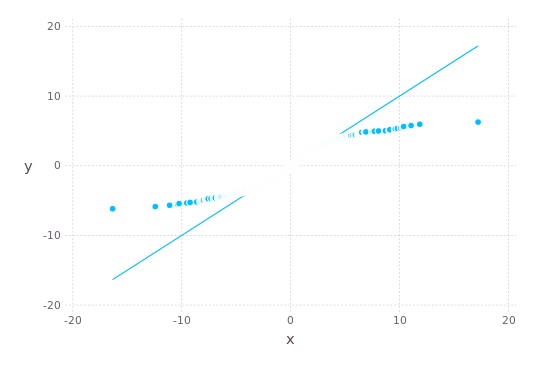

In [45]:
normVals = quantile(normFit, yVals)

plot(layer(x=xVals, y=normVals, Geom.point),
layer(x=[minimum(xVals), maximum(xVals)], y=[minimum(xVals), maximum(xVals)], Geom.line))

# *VaR* and *ES*

### Historical simulation

- *VaR*:

In [60]:
alpha = 0.98
logLosses = -logRets

varHS = quantile(logLosses, alpha)

3.8419575995586728

- expected shortfall:

In [87]:
function empES(x::Array{Float64, 1}, alphas::Array{Float64, 1})
    nVars = length(alphas)
    varHS = quantile(x, alphas)
    esHS = Array(Float64, nVars)
        
    for ii=1:nVars
        exceedances = x[x .> varHS[ii]]
        esHS[ii] = mean(exceedances)
    end
    return esHS
end

empES(logLosses, [alpha])

1-element Array{Float64,1}:
 5.42294

### Under normality

- *VaR*: using

\begin{equation*}
\text{VaR}_{\alpha}=\mu_{L}+\sigma\Phi^{-1}(\alpha)
\end{equation*}


In [67]:
muL = -muHat
sigma = sigmaHat
varNorm = muL + sigma*quantile(Normal(), alpha)

3.4578904615592325

- expected shortfall: using
\begin{equation*}
\text{ES}_{\alpha}=\mu_{L}+\sigma \frac{\phi\left( \Phi^{-1}(\alpha) \right) }{1-\alpha}
\end{equation*}


In [68]:
esNorm = muL + sigma*(pdf(Normal(), quantile(Normal(), alpha))/(1-alpha))

4.084860801591298

In [58]:
varNorm = quantile(normFit, alpha)

(varHS, varNorm)

(3.8419575995586728,3.5562018872574974)

# Simulation study: estimation error

In [88]:
distr = TDist(3)
alphas = [0.99, 0.995, 0.999]

nReps = 100000
nObs = 2500

# preallocation
simVals = Array(Float64, nObs)

simVar = Array(Float64, nReps, length(alphas))
simES = Array(Float64, nReps, length(alphas))

@time begin
    for ii=1:nReps
        simVals = rand(distr, nObs)
        simVar[ii, :] = quantile(simVals, alphas)
        simES[ii, :] = empES(simVals, alphas)
    end
end

elapsed time: 89.724557294 seconds (10676783688 bytes allocated, 17.22% gc time)


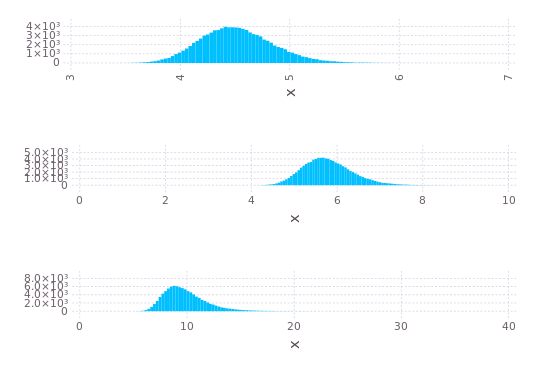

In [89]:
ps = [plot(x=simVar[:, ii][:], Geom.histogram(bincount = 100)) for ii=1:length(alphas)]

vstack(ps...)

In [85]:
trueVars = quantile(distr, alphas)

mserrors = Float64[mean((simVar[:, ii] - trueVars[ii]).^2) for ii=1:length(alphas)]

3-element Array{Float64,1}:
 0.111177
 0.332143
 4.17022 

### Probability integral transforms

Note: only use AFTER theory on functions applied to random variables

- due to 
    \begin{equation*}
    F_{X}(X)\sim \mathbb{U}([0,1])
    \end{equation*}
    application of the fitted cdf to the data should give uniformly distributed values

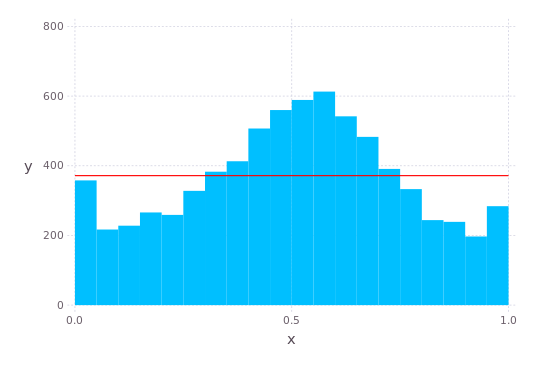

In [53]:
uVals = cdf(normFit, logRets)

nBins = 20
plot(layer(x=uVals, Geom.histogram(bincount = nBins)),
layer(x=[0,1], y=size(logRets,1)./nBins*[1 1], Geom.line,  Theme(default_color=color("red"))))

### fit Student's *t*-distribution

pdf:

$$
\begin{equation*}
f(x_{i};\nu)=\frac{\Gamma\left( \frac{\nu+1}{2} \right) }{\sqrt{\nu\pi}\Gamma\left( \frac{\nu}{2} \right)  }\left( 1+\frac{x_{i}^{2}}{\nu} \right)^{-\frac{\nu+1}{2}}
\end{equation*}
$$

- implementation

In [ ]:
# determine individual likelihoods for a points vector
function t_lh(x::Array{Float64, 1}, nu::Float64)
    return gamma((nu+1)/2)*(nu*pi)^(-0.5)/gamma(nu/2)*(1+x.^2/nu).^(-(nu+1)/2);  
end

function t_negLlh(x::Array{Float64,1}, nu::Float64)
    return -sum(log(t_lh(x, nu)))
end

- unit test

In [ ]:
@test_approx_eq t_lh(logRets, 3.2) pdf(TDist(3.2), logRets)

- specify fitting function

In [ ]:
function tFit(x::Array{Float64})
    tCount = 0 # keep track of # function evaluations

    function objFunc(x::Vector, grad::Vector)
        if length(grad) > 0
        end

        global count
        count::Int += 1
    
        return t_negLlh(logRets, x[1])
    end

    opt = Opt(:LN_COBYLA, 1)
    lower_bounds!(opt, 1.)
    xtol_rel!(opt,1e-8)

    min_objective!(opt, objFunc)

    (minf,minx,ret) = optimize(opt, [10.])
    println("got $minf at $minx after $count iterations (returned $ret)")
    
    return minx
end

- **fit** Student's *t*-distribution

In [ ]:
nuHat = tFit(logRets)

[t-location-scale](https://grollchristian.wordpress.com/2013/04/30/students-t-location-scale/)

we define the linearly transformed variable:

$$Y:=aX+b,\quad X\sim t$$

hence, for the first two moments we get:

\begin{align*}
\mathbb{E}[Y]&=a \mathbb{E}[X]+b \\
&=a\cdot 0 + b \\
&=b 
\end{align*}

\begin{align*}
\mathbb{V}(Y)&=a^{2} \mathbb{V}(X)\\
&=a^{2} \frac{\nu}{\nu-2}
\end{align*}

we even can calculate the complete distribution:

\begin{align*}
F_{Y}(y)&=\mathbb{P}(Y\leq y)\\
&=\mathbb{P}(aX+b\leq y)\\
&=\mathbb{P}\left(X\leq \frac{y-b}{a}\right)\\
&=F_{X}\left(\frac{y-b}{a}\right)
\end{align*}

## Calculate VaR and ES

In [ ]:
quantile(spLogRetFloat, 0.005)

In [ ]:
quantile(spNormFit, 0.005)

In [ ]:
cdf(spNormFit, minimum(spLogRetFloat))

In [ ]:
plot(layer(x=kk[15000:end], y=yVals[15000:end], Geom.step), 
layer(x=[0, 5], y=[0.99, 0.99], Geom.line, Theme(default_color=color("red"))))